In [65]:
import os
import json
import re
import pandas as pd
import matplotlib.pyplot as plt


def load_all_data(folder_path, ignore_completed=False):
    """
    Iterate over all .json files in folder_path:
      - By default, include only those with quiz['completed'] == True;
      - Rename answer keys that have numeric suffixes (_1, _2, …)
      - Apply renaming logic for post-task-question and post-task-survey keys

    Returns a dict mapping each filename (without extension) to its processed quiz data dict.
    """
    def extract_suffix(key):
        m = re.search(r'_(\d+)$', key)
        return int(m.group(1)) if m else 0

    def remove_suffix(key):
        return re.sub(r'_(\d+)$', '', key)

    all_data = {}
    for fn in os.listdir(folder_path):
        if not fn.lower().endswith('.json'):
            continue
        path = os.path.join(folder_path, fn)
        try:
            with open(path, encoding='utf-8') as f:
                quiz = json.load(f)
        except json.JSONDecodeError:
            continue

        if not ignore_completed and not quiz.get('completed', False):
            continue

        key_name = os.path.splitext(fn)[0]
        all_data[key_name] = quiz

        answers = quiz.get('answers', {})
        if not isinstance(answers, dict):
            continue

        sorted_keys = sorted(answers.keys(), key=extract_suffix)
        new_answers = {}
        last_task = None
        for i, old in enumerate(sorted_keys):
            base = remove_suffix(old)

            if base == 'post-task-question':
                new_key = f"{last_task}_post-task-question" if last_task else base
            elif base.startswith('post-task-survey'):
                if i > 0:
                    prev = sorted_keys[i-1]
                    prev_base = remove_suffix(prev)
                    suffix = prev_base[prev_base.rfind('-'):] if '-' in prev_base else ''
                    new_key = base + suffix
                else:
                    new_key = base
                last_task = None
            else:
                new_key = base
                last_task = base

            new_answers[new_key] = answers[old]

        quiz['answers'] = new_answers

    return all_data

def time_analysis(all_data, metric='total_duration_min'):
    """
    Parameters:
      all_data (dict): The dictionary returned by load_quiz_data.

    Returns:
      df_task_level (pandas.DataFrame):
        A DataFrame with one row per task, including columns for start time, end time, duration, and format.
      df_participant_level (pandas.DataFrame):
        A DataFrame with one row per participant, including columns for total duration and format.
    """
    task_rows = []
    part_rows = []

    for fn, quiz in all_data.items():
        answers = quiz.get('answers', {})
        # look for participantId
        pid = fn
        for info in answers.values():
            if isinstance(info, dict):
                ans = info.get('answer', {})
                if isinstance(ans, dict) and 'prolificId' in ans:
                    pid = ans['prolificId']
                    break

        # extract  format
        current_format = None
        total_sec = 0
        temp = []
        for name, info in answers.items():
            if not isinstance(info, dict):
                continue
            st = info.get('startTime')
            ed = info.get('endTime')
            if st is not None and ed is not None:
                dur = (ed - st)/1000.0
            else:
                dur = None

            # tutorial-<fmt>-part1
            if current_format is None:
                m = re.match(r'tutorial-(\w+)-part1', name)
                if m:
                    current_format = m.group(1).lower()

            temp.append({
                'participantId': pid,
                'task': name,
                'startTime': st,
                'endTime': ed,
                'duration_sec': dur,
                'duration_min': dur/60 if dur is not None else None
            })
            if dur:
                total_sec += dur

        # add format 
        fmt = current_format or 'unknown'
        for row in temp:
            row['format'] = fmt
            task_rows.append(row)

        part_rows.append({
            'participantId': pid,
            'format': fmt,
            'duration_sec': round(total_sec,3),
            'duration_min': round(total_sec/60,2)
        })

    df_task = pd.DataFrame(task_rows)
    df_part = pd.DataFrame(part_rows)
    def clean(name, fmt):
        if fmt and fmt!='unknown':
            return name.replace(f"-{fmt}", "")
        return name

    df_task['task'] = df_task.apply(lambda r: clean(r['task'], r['format']), axis=1)
    format_stat = df_part['format'].value_counts()
    total_participant = len(df_part)
    print(f"Total number of valid participants: {total_participant}")

    return df_task, df_part, format_stat



In [66]:
import sys
sys.path.append('/Users/shiyihe/Desktop/USABILITY_ANALYSIS')   

# load data , rename task name, etc,.
folder = '/Users/shiyihe/Desktop/USABILITY_ANALYSIS/tabular'
# folder = '/Users/shiyihe/Desktop/USABILITY_ANALYSIS/config'
# folder = '/Users/shiyihe/Desktop/USABILITY_ANALYSIS/test_all_data'
all_data = load_all_data(folder, ignore_completed=True)
df_task, df_part, format_stat= time_analysis(all_data)
format_stat

Total number of valid participants: 106


format
json     17
json5    15
hjson    15
yaml     15
jsonc    15
xml      15
toml     14
Name: count, dtype: int64

In [67]:
import pandas as pd

def _get_participant_id(answers: dict) -> str:
    for content in answers.values():
        if not isinstance(content, dict):
            continue
        ans = content.get('answer', {}) or {}
        if isinstance(ans, dict) and 'prolificId' in ans:
            return ans['prolificId']
    return None


def extract_writing_tasks(all_data: dict) -> pd.DataFrame:
    """
      - writing-task-NL
      - writing-task-tabular-<format>
      - modifying-task-tabular-<format>-<number>

    return:
      participant_id, component, format,
      code, start_time, end_time, duration_sec, help_count
    """
    rows = []
    for _, session in all_data.items():
        answers = session.get('answers', {})
        pid = _get_participant_id(answers)

        for content in answers.values():
            if not isinstance(content, dict):
                continue
            name = content.get('componentName', '')
            if name == 'writing-task-NL' \
               or name.startswith('writing-task-tabular-') \
               or name.startswith('modifying-task-tabular-'):

                # format
                parts = name.split('-')
                if name == 'writing-task-NL':
                    fmt = 'NL'
                elif name.startswith('writing-task-tabular-'):
                    fmt = parts[-1]
                else:
                    fmt = parts[-2]

                # times
                st = content.get('startTime')
                ed = content.get('endTime')
                dur = (ed - st) / 1000.0 if st is not None and ed is not None else None

                # code
                ans = content.get('answer', {}) or {}
                code = ans.get('code')

                # help clicks
                help_count = content.get('helpButtonClickedCount')

                rows.append({
                    'participantId': pid,
                    'task':      name,
                    'format':         fmt,
                    'code':           code,
                    'start_time':     st,
                    'end_time':       ed,
                    'duration_sec':   dur,
                    'help_count':     help_count
                })

    return pd.DataFrame(rows)


def extract_reading_tasks(all_data: dict) -> pd.DataFrame:
    """
      - reading-task-tabular-<format>-<number>

    return:
      participant_id, component, format,
      response, start_time, end_time, duration_sec, help_count
    """
    rows = []
    for _, session in all_data.items():
        answers = session.get('answers', {})
        pid = _get_participant_id(answers)

        for content in answers.values():
            if not isinstance(content, dict):
                continue
            name = content.get('componentName', '')
            if name.startswith('reading-task-tabular-'):
                parts = name.split('-')
                fmt = parts[-2]
                num = parts[-1]

                # 回答键
                q_key = f"reading-task-tabular-{fmt}_q{num}"
                ans = content.get('answer', {}) or {}
                resp = ans.get(q_key)

                st = content.get('startTime')
                ed = content.get('endTime')
                dur = (ed - st) / 1000.0 if st is not None and ed is not None else None
                help_count = content.get('helpButtonClickedCount')

                rows.append({
                    'participantId': pid,
                    'task':      name,
                    'format':         fmt,
                    'response':       resp,
                    'start_time':     st,
                    'end_time':       ed,
                    'duration_sec':   dur,
                    'help_count':     help_count
                })

    return pd.DataFrame(rows)

def extract_writing_nl_tasks(all_data: dict) -> pd.DataFrame:
    """
    专门提取 writing-task-NL 任务

    返回字段：participant_id, component, format='NL',
              code, start_time, end_time, duration_sec, help_count
    """
    rows = []
    for session in all_data.values():
        answers = session.get('answers', {})
        pid = _get_participant_id(answers)
        content = answers.get('writing-task-NL')
        if isinstance(content, dict):
            st = content.get('startTime')
            ed = content.get('endTime')
            dur = (ed - st) / 1000.0 if st is not None and ed is not None else None
            ans = content.get('answer', {}) or {}
            code = ans.get('code')
            help_count = content.get('helpButtonClickedCount')
            rows.append({
                'participantId': pid,
                'task':      'writing-task-NL',
                'format':         'NL',
                'code':           code,
                'start_time':     st,
                'end_time':       ed,
                'duration_sec':   dur,
                'help_count':     help_count
            })
    return pd.DataFrame(rows)


def extract_writing_tabular_tasks(all_data: dict) -> pd.DataFrame:
    """
    专门提取 writing-task-tabular-<format> 任务

    返回字段：participant_id, component, format,
              code, start_time, end_time, duration_sec, help_count
    """
    rows = []
    for session in all_data.values():
        answers = session.get('answers', {})
        pid = _get_participant_id(answers)
        for content in answers.values():
            if not isinstance(content, dict):
                continue
            name = content.get('componentName', '')
            if name.startswith('writing-task-tabular-'):
                fmt = name.split('-')[-1]
                st = content.get('startTime')
                ed = content.get('endTime')
                dur = (ed - st) / 1000.0 if st is not None and ed is not None else None
                ans = content.get('answer', {}) or {}
                code = ans.get('code')
                help_count = content.get('helpButtonClickedCount')
                rows.append({
                    'participantId': pid,
                    'task':      name,
                    'format':         fmt,
                    'code':           code,
                    'start_time':     st,
                    'end_time':       ed,
                    'duration_sec':   dur,
                    'help_count':     help_count
                })
    return pd.DataFrame(rows)


def extract_modifying_tabular_tasks(all_data: dict) -> pd.DataFrame:
    """
    专门提取 modifying-task-tabular-<format>-<number> 任务

    返回字段：participant_id, component, format,
              code, start_time, end_time, duration_sec, help_count
    """
    rows = []
    for session in all_data.values():
        answers = session.get('answers', {})
        pid = _get_participant_id(answers)
        for content in answers.values():
            if not isinstance(content, dict):
                continue
            name = content.get('componentName', '')
            if name.startswith('modifying-task-tabular-'):
                parts = name.split('-')
                fmt = parts[-2]
                st = content.get('startTime')
                ed = content.get('endTime')
                dur = (ed - st) / 1000.0 if st is not None and ed is not None else None
                ans = content.get('answer', {}) or {}
                code = ans.get('code')
                help_count = content.get('helpButtonClickedCount')
                rows.append({
                    'participantId': pid,
                    'task':      name,
                    'format':         fmt,
                    'code':           code,
                    'start_time':     st,
                    'end_time':       ed,
                    'duration_sec':   dur,
                    'help_count':     help_count
                })
    return pd.DataFrame(rows)


df_writing_nl = extract_writing_nl_tasks(all_data)
df_writing_tabular = extract_writing_tabular_tasks(all_data)
df_modifying_tabular = extract_modifying_tabular_tasks(all_data)
df_reading = extract_reading_tasks(all_data)

In [68]:
def merge_dfs(df1: pd.DataFrame, df2: pd.DataFrame,
              on_cols: list, how: str = 'inner') -> pd.DataFrame:
    """
    根据指定列合并两个 DataFrame。

    参数：
      df1, df2: 待合并的 DataFrame
      on_cols:   用于合并的列名列表
      how:       合并方式，如 'inner', 'left', 'right', 'outer'

    返回合并后的 DataFrame。
    """
    merged = pd.merge(df1, df2, on=on_cols, how=how)
    return merged

df_merged = merge_dfs(df1=df_tab_norm, df2=some_other_df,
                      on_cols=['participant_id', 'format'],
                      how='inner')

NameError: name 'some_other_df' is not defined

In [32]:
def normalize_typing_time(df_nl: pd.DataFrame, df_tab: pd.DataFrame,
                          keep_baseline: bool = True) -> pd.DataFrame:
    """
    归一化打字时间：
      - df_nl: baseline writing-task-NL 数据
      - df_tab: writing-task-tabular 任务
      - keep_baseline: 是否保留 baseline 条目

    计算每位 participant 的基线速率：sec_per_char = duration_sec / char_count
    为两个 DataFrame 增加 char_count 和 normalized_time。
    最后根据 keep_baseline 决定返回全部记录或仅表格任务结果。
    """
    # 1. 基线速率
    df_nl2 = df_nl.copy()
    df_nl2['char_count'] = df_nl2['code'].astype(str).str.len()
    df_nl2['sec_per_char'] = df_nl2['duration_sec'] / df_nl2['char_count']
    df_nl2['normalized_time'] = df_nl2['duration_sec'] / df_nl2['sec_per_char']

    # 2. 表格任务
    df_tab2 = df_tab.copy()
    df_tab2['char_count'] = df_tab2['code'].astype(str).str.len()
    df_tab2 = df_tab2.merge(
        df_nl2[['participantId', 'sec_per_char']],
        on='participantId', how='left'
    )
    df_tab2['normalized_time'] = df_tab2['duration_sec'] / df_tab2['sec_per_char']

    # 3. 返回
    if keep_baseline:
        return pd.concat([df_nl2, df_tab2], ignore_index=True, sort=False)
    else:
        return df_tab2

df_tab_norm = normalize_typing_time(df_writing_nl, df_writing_tabular, keep_baseline=False)
df_tab_norm

,participantId,task,format,code,start_time,end_time,duration_sec,help_count,char_count,sec_per_char,normalized_time
0,64457bc906c125cebd4bf66b,writing-task-tabular-json5,json5,"{\n ""person"": \n""name"": {\n ""treatment""{\...",1746561717576,1746561968418,250.842,10,157,0.452557,554.277309
1,6697c8b6d9d7baa7edd8c4d3,writing-task-tabular-hjson,hjson,patients: [\n {\n name: John\n ...,1745932567200,1745933142854,575.654,0,426,0.612992,939.088928
2,67e25388d573ec2d5f1c8442,writing-task-tabular-yaml,yaml,person:\n name: John\ntests\n # id:1\n norm...,1746146837797,1746147375040,537.243,2,179,1.154984,465.151847
3,67e5cf90b79d0874e1cf16b0,writing-task-tabular-toml,toml,"[patients]\n[[patients.patient]]\nname = ""John...",1746145745579,1746146463120,717.541,2,292,1.287310,557.395861
4,67d00f24466a67ba7e41228e,writing-task-tabular-toml,toml,"[[patients]]\n[[users]]\nname = ""john""\n[tests...",1745930601970,1745932342937,1740.967,11,246,1.217092,1430.431283
...,...,...,...,...,...,...,...,...,...,...,...
101,67ab650c320eccf6141d4010,writing-task-tabular-jsonc,jsonc,"""name"" John""\n""id"": 2\n""results"" ""normal""\n""id...",1746146024272,1746147272533,1248.261,3,159,2.252583,554.146424
102,65fad673a546ab14baf2f8d3,writing-task-tabular-json5,json5,"{\n patients: {\n {\n name:'John',\n ...",1745930426793,1745931203100,776.307,0,263,1.018746,762.022109
103,67f1c7bd6f1c4a3d8deae02f,writing-task-tabular-toml,toml,"penalities = [""name"",""tests"",treatment]\ntreat...",1746145051620,1746145550967,499.347,0,184,1.102308,453.001216
104,67adb27bd5f5776fcb16da62,writing-task-tabular-hjson,hjson,patients: [\n\n{\nname: John \ntests : [\n ...,1746146238628,1746146764449,525.821,0,154,1.530616,343.535471


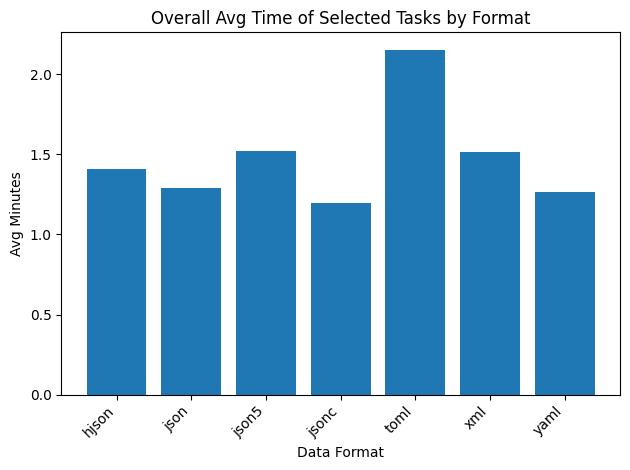

,format,average_duration_min
0,hjson,1.408947
1,json,1.289103
2,json5,1.520697
3,jsonc,1.195805
4,toml,2.154509
5,xml,1.515769
6,yaml,1.265393


In [3]:
import matplotlib.pyplot as plt
import pandas as pd
from typing import Tuple

def summarize_and_plot_tasks_by_format(
    df_task: pd.DataFrame,
    task_list: list,
    metric: str = 'duration_min',
    mode: str = 'overall',
    title: str = 'Average Time by Format',
    xlabel: str = 'Format',
    ylabel: str = None
) -> Tuple[pd.DataFrame, plt.Figure]:

    avg_col = f'average_{metric}'
    # 1) 过滤
    df_filtered = df_task[df_task['task'].isin(task_list)]
    
    # 2) 汇总
    if mode == 'overall':
        summary = (
            df_filtered
            .groupby('format')[metric]
            .mean()
            .reset_index()
            .rename(columns={metric: avg_col})
        )
    elif mode == 'by_task':
        summary = (
            df_filtered
            .groupby(['format', 'task'])[metric]
            .mean()
            .reset_index()
            .rename(columns={metric: avg_col})
        )
    else:
        raise ValueError("mode must be 'overall' or 'by_task'")
    
    # 3) 绘图
    fig, ax = plt.subplots()
    if mode == 'overall':
        ax.bar(summary['format'], summary[avg_col])
    else:
        pivot = summary.pivot(index='format', columns='task', values=avg_col)
        pivot.plot(kind='bar', ax=ax)
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel or f'Average {metric}')
    ax.set_title(title)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    
    return summary, fig



summary_df, fig = summarize_and_plot_tasks_by_format(
    df_task,
    task_list=['reading-task-tabular-1', 'reading-task-tabular-2', 'reading-task-tabular-3', 'reading-task-tabular-4', 'reading-task-tabular-5'],
    metric='duration_min',
    mode='overall', # overall or by_task
    title='Overall Avg Time of Selected Tasks by Format',
    xlabel='Data Format',
    ylabel='Avg Minutes'
)
plt.show()

summary_df

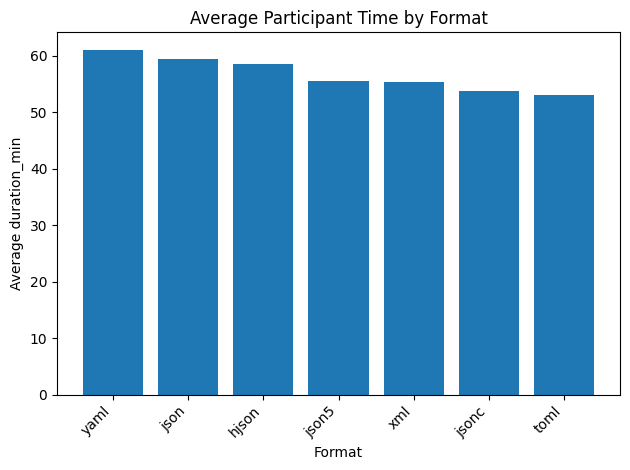

In [4]:
def summarize_and_plot_participant_time_by_format(df_part,
                                    metric='duration_min',
                                    title='Average Participant Time by Format',
                                    xlabel='Format',
                                    ylabel=None):
    """
    Plot a bar chart of average participant times by format,
    supporting custom chart title and axis labels.
    """
    summary = df_part.groupby('format')[metric].mean().reset_index()
    avg_col = f'{metric}'
    summary = summary.rename(columns={metric: avg_col})
    df_summary=summary.sort_values(by=avg_col, ascending=False)
    fig, ax = plt.subplots()
    ax.bar(df_summary['format'], df_summary[metric])
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel or f'Average {metric}')
    ax.set_title(title)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    return fig

fig = summarize_and_plot_participant_time_by_format(df_part,
                                    metric='duration_min',
                                    title='Average Participant Time by Format',
                                    xlabel='Format',
                                    ylabel=None)

plt.show()

In [7]:
df_task['task'].unique()

array(['introduction', 'qualifications', 'consent', 'task',
       'writing-task-NL', 'writing-task-NL_post-task-question',
       'tutorial-part1', 'tutorial-part2', 'reading-task-tabular-1',
       'reading-task-tabular-1_post-task-question',
       'reading-task-tabular-2',
       'reading-task-tabular-2_post-task-question',
       'reading-task-tabular-3',
       'reading-task-tabular-3_post-task-question',
       'reading-task-tabular-4',
       'reading-task-tabular-4_post-task-question',
       'reading-task-tabular-5',
       'reading-task-tabular-5_post-task-question',
       'writing-task-tabular', 'writing-task-tabular_post-task-question',
       'modifying-task-tabular-1',
       'modifying-task-tabular-1_post-task-question',
       'modifying-task-tabular-2',
       'modifying-task-tabular-2_post-task-question',
       'modifying-task-tabular-3',
       'modifying-task-tabular-3_post-task-question',
       'modifying-task-tabular-4',
       'modifying-task-tabular-4_post-t

In [34]:
df_tab_norm_time=df_tab_norm[['participantId', 'format', 'task', 'duration_sec', 'normalized_time']]
df_tab_norm_time

,participantId,format,task,duration_sec,normalized_time
0,64457bc906c125cebd4bf66b,json5,writing-task-tabular-json5,250.842,554.277309
1,6697c8b6d9d7baa7edd8c4d3,hjson,writing-task-tabular-hjson,575.654,939.088928
2,67e25388d573ec2d5f1c8442,yaml,writing-task-tabular-yaml,537.243,465.151847
3,67e5cf90b79d0874e1cf16b0,toml,writing-task-tabular-toml,717.541,557.395861
4,67d00f24466a67ba7e41228e,toml,writing-task-tabular-toml,1740.967,1430.431283
...,...,...,...,...,...
101,67ab650c320eccf6141d4010,jsonc,writing-task-tabular-jsonc,1248.261,554.146424
102,65fad673a546ab14baf2f8d3,json5,writing-task-tabular-json5,776.307,762.022109
103,67f1c7bd6f1c4a3d8deae02f,toml,writing-task-tabular-toml,499.347,453.001216
104,67adb27bd5f5776fcb16da62,hjson,writing-task-tabular-hjson,525.821,343.535471


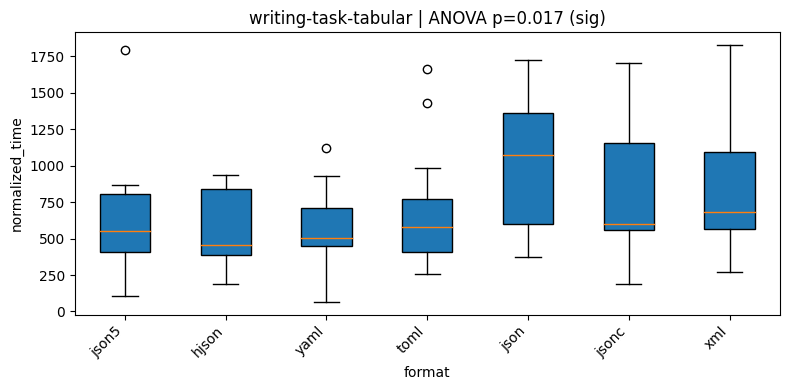

,task,homogeneity_p,test,test_p,significant,posthoc
0,writing-task-tabular,0.469907,ANOVA,0.017413,True,"[hjson vs json, json vs yaml]"


In [50]:
def clean_task_column(
    df,
    task_col: str = 'task',
    format_col: str = 'format'
):
    """
    去除 df[task_col] 中末尾的 -<format> 后缀。
    
    例如：
      writing-task-tabular-json5 (format=json5) → writing-task-tabular
      reading-task-tabular-xml-1 (format=xml) → reading-task-tabular-1
    """
    df = df.copy()
    def _strip(row):
        task = row[task_col]
        fmt  = row[format_col]
        # 仅删除末尾的 -<fmt>
        return re.sub(f'-{re.escape(fmt)}$', '', task)
    df[task_col] = df.apply(_strip, axis=1)
    return df

def analyze_metric_differences(
    df: pd.DataFrame,
    task_col: str,
    group_col: str,
    metric_col: str,
    alpha: float = 0.05,
    clean_suffix: bool = True,
    figsize: tuple = (8, 4)
) -> pd.DataFrame:
    """
    按 task_col 分组，对 group_col 的 metric_col 做显著性检验并可视化。

    参数：
      df: 包含 task_col, group_col, metric_col 的 DataFrame
      task_col: 列名，用于分任务；可以自动去除 -format 后缀
      group_col: 列名，用于分组比较（如 format）
      metric_col: 列名，用作比较的指标
      alpha: 显著性水平
      clean_suffix: 是否先去除 task_col 中的 -<format> 后缀
      figsize: 绘图尺寸

    返回:
      DataFrame，包含每个 task 的:
        task, homogeneity_p, test, test_p, significant, posthoc
    """
    # 可选清理后缀
    if clean_suffix:
        df = clean_task_column(df, task_col=task_col, format_col=group_col)

    records = []
    for task in df[task_col].unique():
        sub = df[df[task_col] == task].dropna(subset=[metric_col])
        groups = sub[group_col].unique()
        # 至少两个组才能比较
        if len(groups) < 2:
            records.append({
                'task': task,
                'homogeneity_p': None,
                'test': None,
                'test_p': None,
                'significant': False,
                'posthoc': []
            })
            continue
        data_by_group = [sub.loc[sub[group_col] == g, metric_col].values for g in groups]

        # 1) Levene 检验
        _, p_lev = levene(*data_by_group)
        homogeneity = (p_lev >= alpha)

        # 2) 主效应检验
        if homogeneity:
            _, p_main = f_oneway(*data_by_group)
            test_name = 'ANOVA'
        else:
            try:
                _, p_main = kruskal(*data_by_group)
                test_name = 'Kruskal-Wallis'
            except ValueError as e:
                if 'All numbers are identical' in str(e):
                    p_main = 1.0
                    test_name = 'Kruskal-Wallis (identical)'
                else:
                    raise
        sig = (p_main < alpha)

        # 3) 事后分析
        posthoc = []
        if sig:
            if homogeneity:
                tukey = pairwise_tukeyhsd(endog=sub[metric_col], groups=sub[group_col], alpha=alpha)
                for row in tukey.summary().data[1:]:
                    g1, g2, *_, reject = row
                    if reject:
                        posthoc.append(f"{g1} vs {g2}")
            else:
                combs = list(itertools.combinations(groups, 2))
                alpha_adj = alpha / len(combs)
                for g1, g2 in combs:
                    d1 = sub.loc[sub[group_col] == g1, metric_col]
                    d2 = sub.loc[sub[group_col] == g2, metric_col]
                    _, p_u = mannwhitneyu(d1, d2, alternative='two-sided')
                    if p_u < alpha_adj:
                        posthoc.append(f"{g1} vs {g2}")

        # 4) 可视化箱型图
        fig, ax = plt.subplots(figsize=figsize)
        ax.boxplot(data_by_group, labels=groups, patch_artist=True)
        ax.set_title(f"{task} | {test_name} p={p_main:.3f} {'(sig)' if sig else '(ns)'}")
        ax.set_xlabel(group_col)
        ax.set_ylabel(metric_col)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

        # 5) 汇总记录
        records.append({
            'task': task,
            'homogeneity_p': p_lev,
            'test': test_name,
            'test_p': p_main,
            'significant': sig,
            'posthoc': posthoc
        })

    return pd.DataFrame(records)

# df_tab_norm_clean = clean_task_column(df_tab_norm, task_col='task', format_col='format')

summary = analyze_metric_differences(
    df=df_tab_norm,
    task_col='task',
    group_col='format',
    metric_col='normalized_time',
    alpha=0.05,
    clean_suffix=True  # 会把 writing-task-tabular-json5 → writing-task-tabular
)

summary
# # show significant results
# print(summary[summary['significant']][['task','test','test_p','posthoc']].to_string())

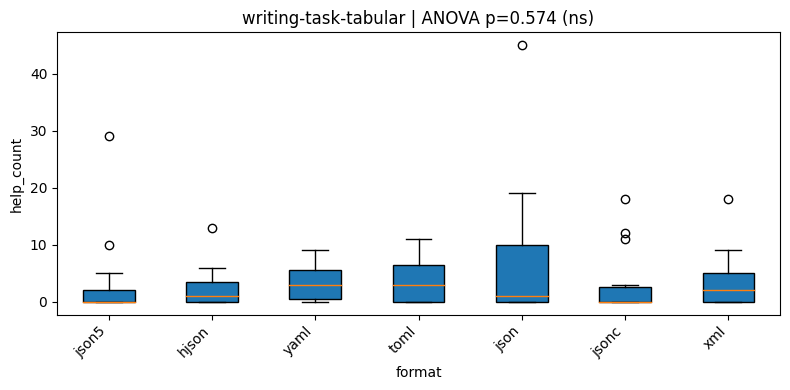

,task,homogeneity_p,test,test_p,significant,posthoc
0,writing-task-tabular,0.441093,ANOVA,0.574159,False,[]


In [49]:
summary1 = analyze_metric_differences(
    df=df_tab_norm,
    task_col='task',
    group_col='format',
    metric_col='help_count',
    alpha=0.05,
    clean_suffix=True  # 会把 writing-task-tabular-json5 → writing-task-tabular
)

summary1

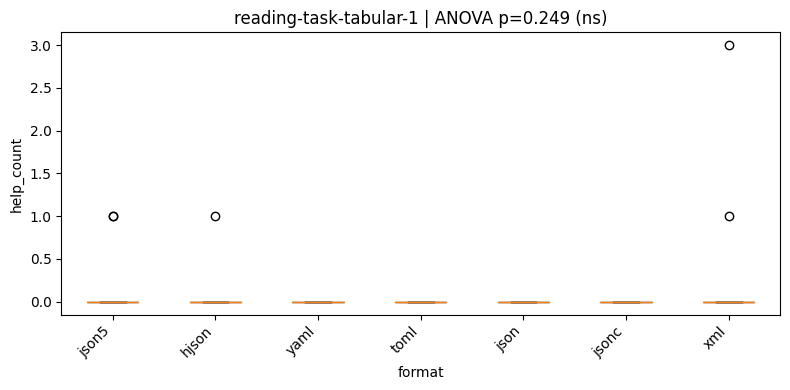

/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_morestats.py:2710: RuntimeWarning: invalid value encountered in double_scalars
  W = numer / denom


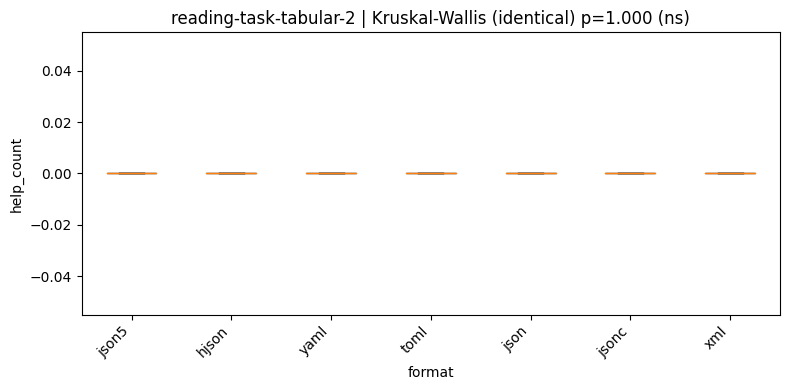

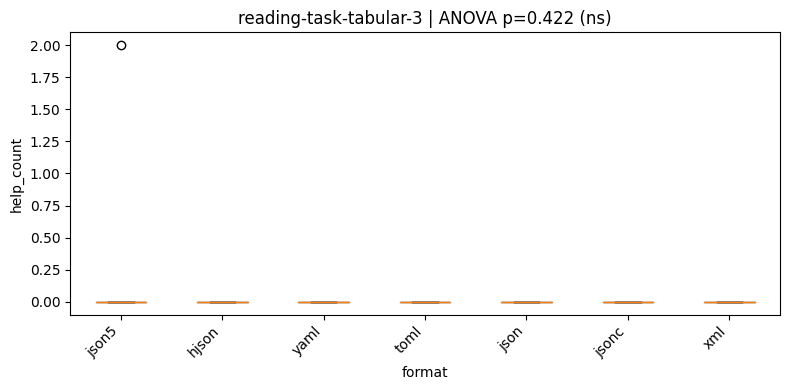

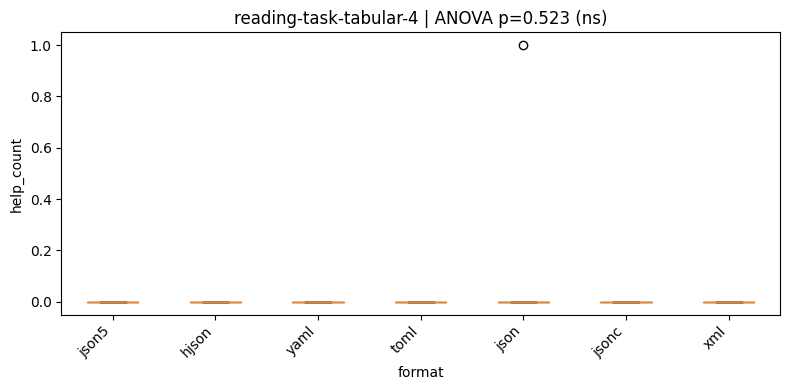

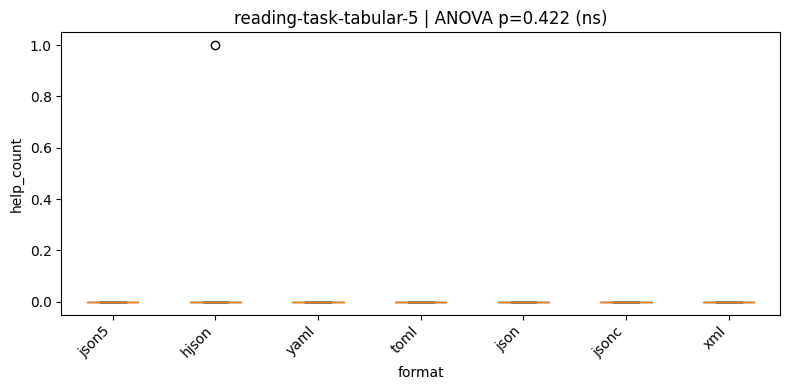

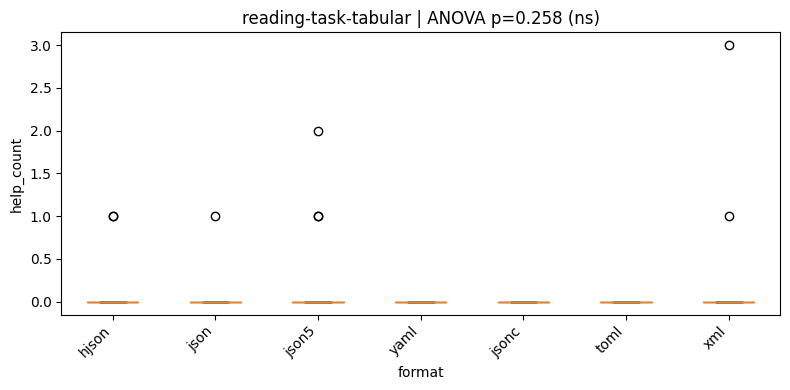

,task,homogeneity_p,test,test_p,significant,posthoc
0,reading-task-tabular-1,0.249339,ANOVA,0.249339,False,[]
1,reading-task-tabular-2,NaN,Kruskal-Wallis (identical),1.000000,False,[]
2,reading-task-tabular-3,0.422121,ANOVA,0.422121,False,[]
3,reading-task-tabular-4,0.522879,ANOVA,0.522879,False,[]
4,reading-task-tabular-5,0.422121,ANOVA,0.422121,False,[]
5,reading-task-tabular,0.257991,ANOVA,0.257991,False,[]


In [58]:
summary2 = analyze_metric_differences(
    df=df_reading_clean,
    task_col='task',
    group_col='format',
    metric_col='help_count',
    alpha=0.05,
    clean_suffix=True  # 会把 writing-task-tabular-json5 → writing-task-tabular
)

summary2

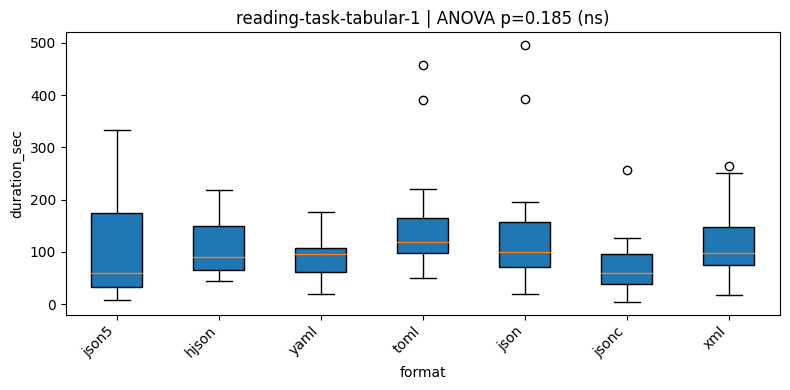

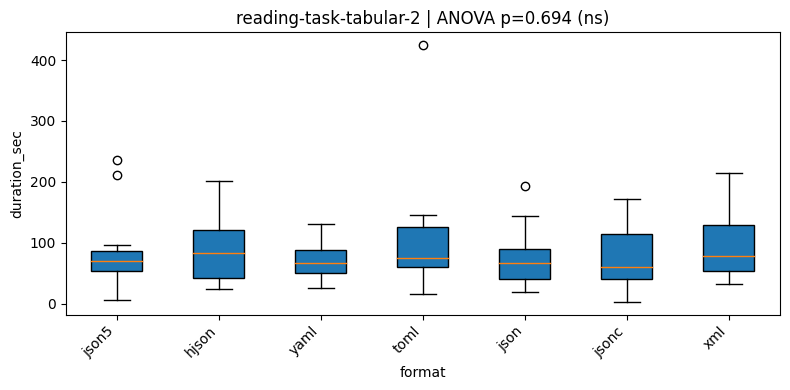

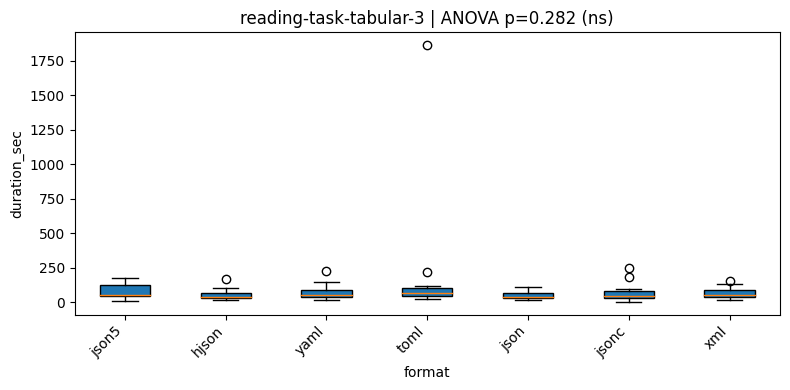

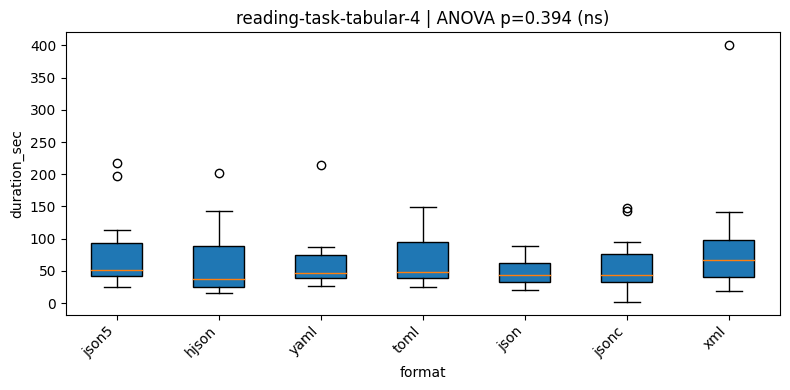

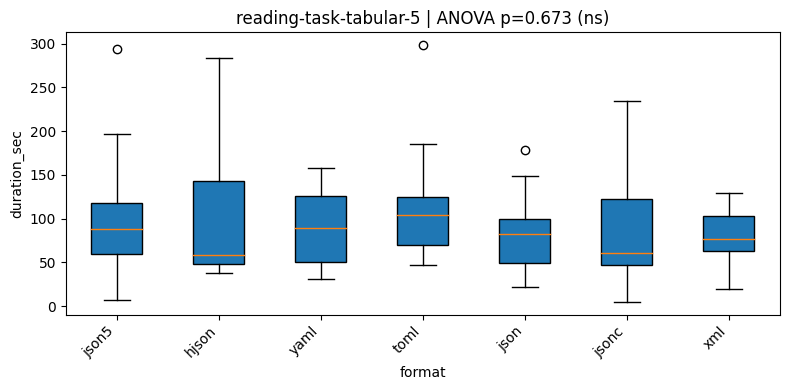

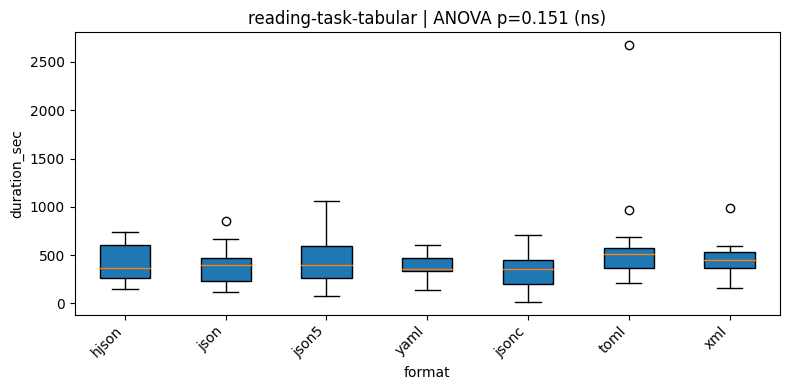

,task,homogeneity_p,test,test_p,significant,posthoc
0,reading-task-tabular-1,0.338326,ANOVA,0.185309,False,[]
1,reading-task-tabular-2,0.732178,ANOVA,0.694480,False,[]
2,reading-task-tabular-3,0.348505,ANOVA,0.282461,False,[]
3,reading-task-tabular-4,0.558429,ANOVA,0.394428,False,[]
4,reading-task-tabular-5,0.495129,ANOVA,0.672755,False,[]
5,reading-task-tabular,0.465146,ANOVA,0.151016,False,[]


In [59]:
summary2 = analyze_metric_differences(
    df=df_reading_clean,
    task_col='task',
    group_col='format',
    metric_col='duration_sec',
    alpha=0.05,
    clean_suffix=True  # 会把 writing-task-tabular-json5 → writing-task-tabular
)

summary2

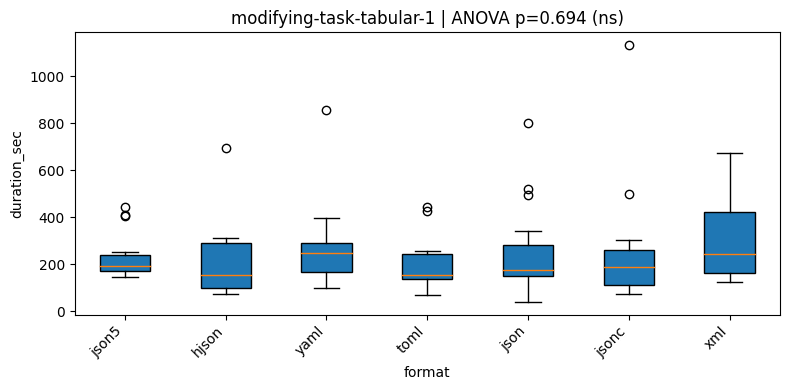

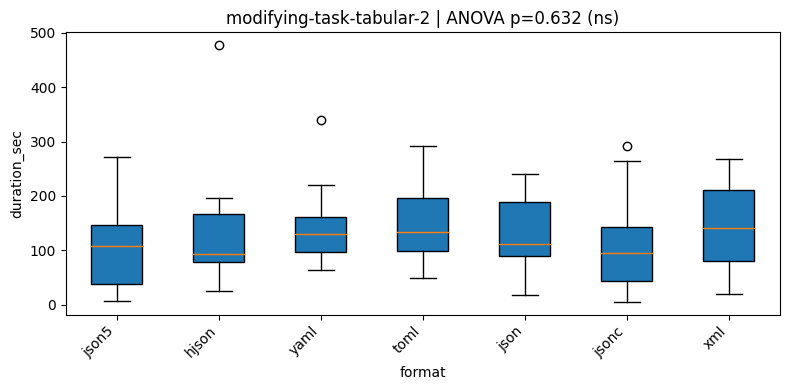

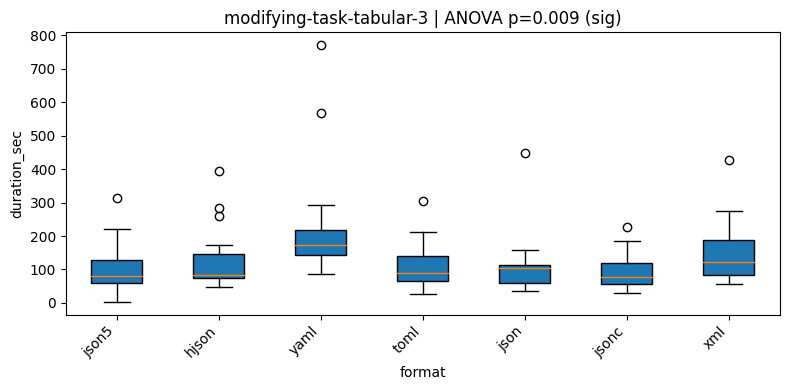

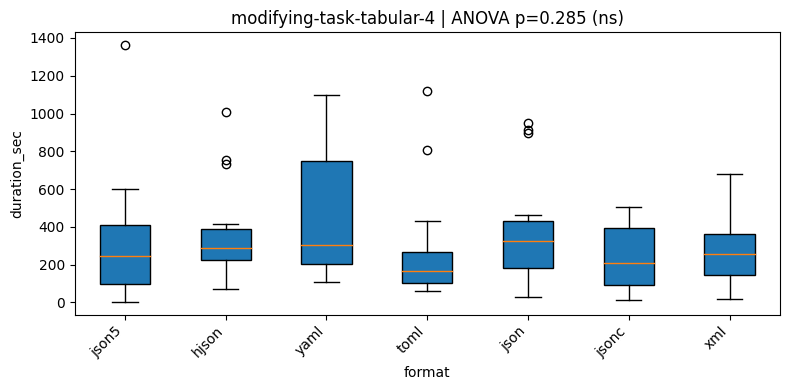

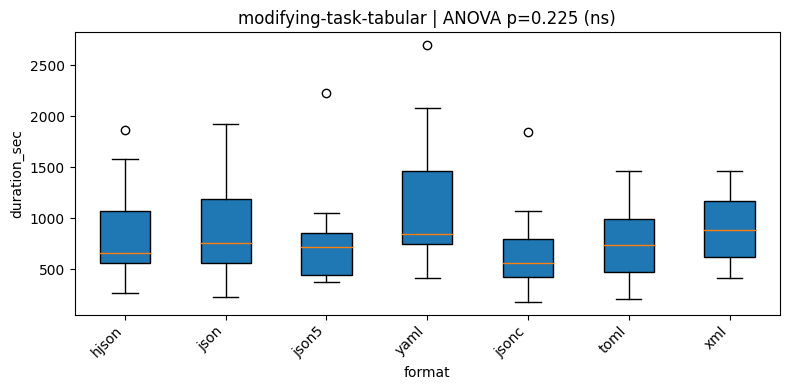

,task,homogeneity_p,test,test_p,significant,posthoc
0,modifying-task-tabular-1,0.789678,ANOVA,0.693573,False,[]
1,modifying-task-tabular-2,0.988812,ANOVA,0.632126,False,[]
2,modifying-task-tabular-3,0.554342,ANOVA,0.009062,True,"[json vs yaml, json5 vs yaml, jsonc vs yaml, t..."
3,modifying-task-tabular-4,0.740686,ANOVA,0.285302,False,[]
4,modifying-task-tabular,0.830471,ANOVA,0.225203,False,[]


In [63]:
summary4 = analyze_metric_differences(
    df=df_modifying_clean,
    task_col='task',
    group_col='format',
    metric_col='duration_sec',
    alpha=0.05,
    clean_suffix=True  # 会把 writing-task-tabular-json5 → writing-task-tabular
)

summary4

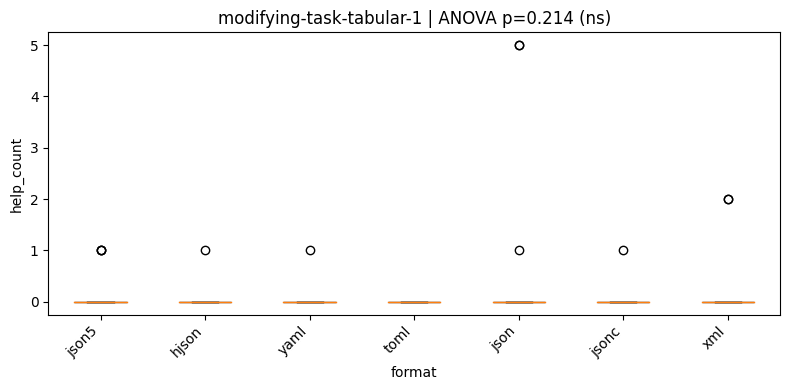

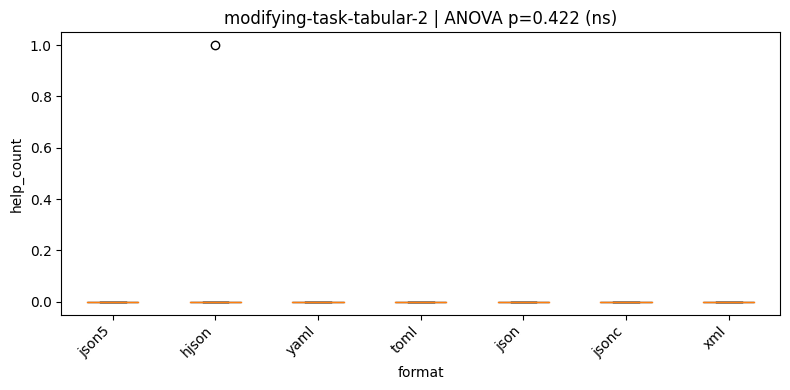

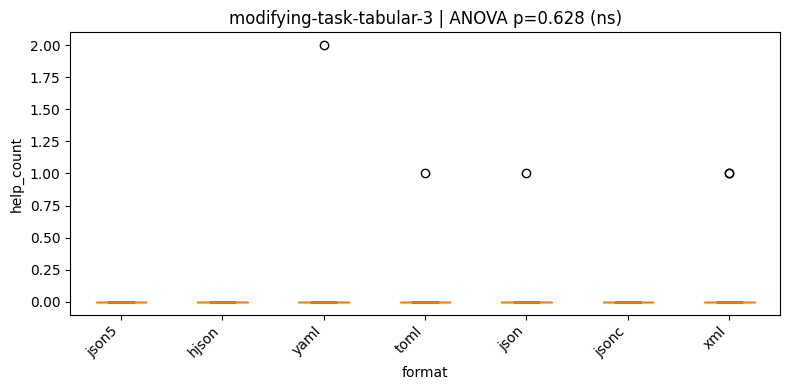

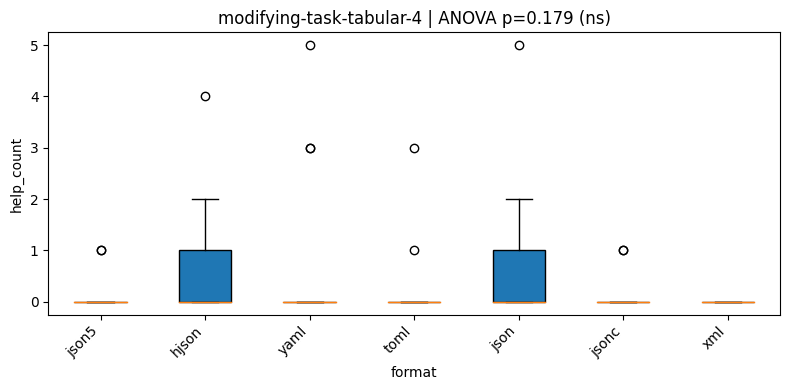

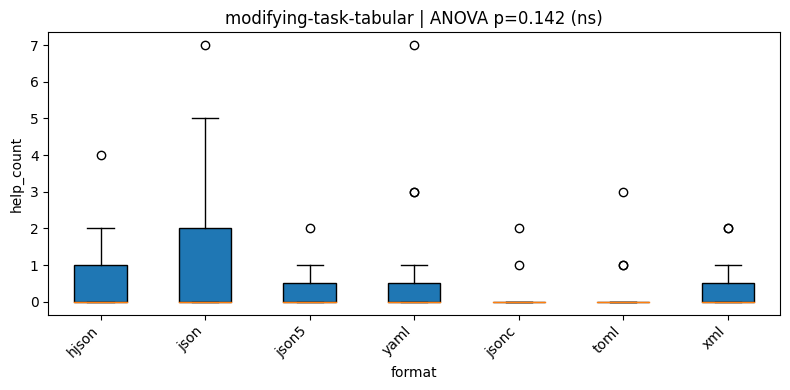

,task,homogeneity_p,test,test_p,significant,posthoc
0,modifying-task-tabular-1,0.214148,ANOVA,0.214148,False,[]
1,modifying-task-tabular-2,0.422121,ANOVA,0.422121,False,[]
2,modifying-task-tabular-3,0.627621,ANOVA,0.627621,False,[]
3,modifying-task-tabular-4,0.178922,ANOVA,0.178922,False,[]
4,modifying-task-tabular,0.141615,ANOVA,0.141615,False,[]


In [64]:
summary5 = analyze_metric_differences(
    df=df_modifying_clean,
    task_col='task',
    group_col='format',
    metric_col='help_count',
    alpha=0.05,
    clean_suffix=True  # 会把 writing-task-tabular-json5 → writing-task-tabular
)

summary5

In [55]:
import re
import pandas as pd

def aggregate_tasks_with_format(
    df: pd.DataFrame,
    participant_col: str = 'participant_id',
    task_col: str = 'task',
    format_col: str = 'format',
    metrics: list = ['duration_sec', 'help_count']
) -> pd.DataFrame:
    """
    对形如 <prefix>-<format>-<number> 的子任务：
      1) 清理中间 '-<format>'，如 reading-task-tabular-json5-1 → reading-task-tabular-1
      2) 生成汇总行（<prefix>），将同 participant+format 下所有数字后缀子任务的 metrics 求和，
         并保留 format

    参数:
      df            包含 participant_id, task, format, metrics 列的 DataFrame
      participant_col: 列名，参与者 ID
      task_col:        列名，任务名称
      format_col:      列名，格式名称
      metrics:         需要聚合的列

    返回:
      DataFrame：包含原始子任务行 + 聚合行，聚合行的 task 列为 prefix（去掉数字后缀）
    """
    df = df.copy()
    # 1) 去掉中间 '-<format>'，仅针对末尾带数字后缀的任务
    def strip_format(task, fmt):
        # pattern: -<fmt> before -number
        return re.sub(fr"-{re.escape(fmt)}(?=-\d+$)", "", task)
    df[task_col] = df.apply(lambda row: strip_format(row[task_col], str(row[format_col])), axis=1)

    # 2) 筛选出带数字后缀的子任务
    mask = df[task_col].str.contains(r"-\d+$", regex=True)
    sub = df[mask].copy()

    # 3) 计算 prefix = 去掉尾部 '-number'
    sub_prefix = sub.copy()
    sub_prefix[task_col] = sub_prefix[task_col].str.replace(r"-\d+$", "", regex=True)

    # 4) 按 participant_id + format + prefix 聚合 metrics
    agg = (
        sub_prefix
        .groupby([participant_col, format_col, task_col], as_index=False)[metrics]
        .sum()
    )

    # 5) 合并原始行和聚合行
    result = pd.concat([df, agg], ignore_index=True, sort=False)
    return result

# 示例用法：
# df_reading_clean = aggregate_tasks_with_format(df_reading)
# df_mod_clean     = aggregate_tasks_with_format(df_modifying)




df_reading_clean = aggregate_tasks_with_format(
    df_reading,
    participant_col='participantId',
    task_col='task',
    format_col = 'format',
    metrics=['duration_sec','help_count']
)

df_reading_clean

,participantId,task,format,response,start_time,end_time,duration_sec,help_count
0,64457bc906c125cebd4bf66b,reading-task-tabular-1,json5,9,1.746560e+12,1.746560e+12,14.824,0
1,64457bc906c125cebd4bf66b,reading-task-tabular-2,json5,quiz2,1.746560e+12,1.746560e+12,72.466,0
2,64457bc906c125cebd4bf66b,reading-task-tabular-3,json5,4,1.746560e+12,1.746560e+12,24.606,0
3,64457bc906c125cebd4bf66b,reading-task-tabular-4,json5,Bob,1.746560e+12,1.746560e+12,26.410,0
4,64457bc906c125cebd4bf66b,reading-task-tabular-5,json5,[Eve],1.746560e+12,1.746560e+12,96.426,0
...,...,...,...,...,...,...,...,...
631,67f1a4f8dd44e7cd5adffa29,reading-task-tabular,json5,NaN,NaN,NaN,1056.874,0
632,67f1c7bd6f1c4a3d8deae02f,reading-task-tabular,toml,NaN,NaN,NaN,577.437,0
633,67f3619e16d4ca195fbd1bd0,reading-task-tabular,yaml,NaN,NaN,NaN,603.879,0
634,67f5bb69760b211cdfe8021c,reading-task-tabular,jsonc,NaN,NaN,NaN,173.583,0


In [57]:
df_reading_clean[df_reading_clean['participantId']=='67f913a9b5c79e960807c7e3']

,participantId,task,format,response,start_time,end_time,duration_sec,help_count
450,67f913a9b5c79e960807c7e3,reading-task-tabular-1,yaml,87,1.745933e+12,1.745933e+12,100.753,0
451,67f913a9b5c79e960807c7e3,reading-task-tabular-2,yaml,quiz2,1.745933e+12,1.745933e+12,83.300,0
452,67f913a9b5c79e960807c7e3,reading-task-tabular-3,yaml,2,1.745933e+12,1.745933e+12,106.493,0
453,67f913a9b5c79e960807c7e3,reading-task-tabular-4,yaml,Bob,1.745933e+12,1.745933e+12,83.694,0
454,67f913a9b5c79e960807c7e3,reading-task-tabular-5,yaml,"[Bob, Alice]",1.745933e+12,1.745933e+12,157.770,0
635,67f913a9b5c79e960807c7e3,reading-task-tabular,yaml,NaN,NaN,NaN,532.010,0


In [61]:
df_modifying_clean = aggregate_tasks_with_format(
    df_modifying_tabular,
    participant_col='participantId',
    task_col='task',
    format_col = 'format',
    metrics=['duration_sec','help_count']
)

df_modifying_clean

,participantId,task,format,code,start_time,end_time,duration_sec,help_count
0,64457bc906c125cebd4bf66b,modifying-task-tabular-1,json5,{\n movies: {\n movie: [\n ...,1.746562e+12,1.746562e+12,156.905,1
1,64457bc906c125cebd4bf66b,modifying-task-tabular-2,json5,{\n movies: {\n movie: [\n ...,1.746562e+12,1.746562e+12,79.302,0
2,64457bc906c125cebd4bf66b,modifying-task-tabular-3,json5,{\n movies: {\n movie: [\n ...,1.746562e+12,1.746562e+12,63.751,0
3,64457bc906c125cebd4bf66b,modifying-task-tabular-4,json5,{\n movies: {\n movie: [\n ...,1.746562e+12,1.746562e+12,129.119,0
4,6697c8b6d9d7baa7edd8c4d3,modifying-task-tabular-1,hjson,{\n movies:\n {\n movie:\n [\n {\...,1.745933e+12,1.745933e+12,311.642,0
...,...,...,...,...,...,...,...,...
525,67f1a4f8dd44e7cd5adffa29,modifying-task-tabular,json5,NaN,NaN,NaN,452.122,0
526,67f1c7bd6f1c4a3d8deae02f,modifying-task-tabular,toml,NaN,NaN,NaN,1048.292,0
527,67f3619e16d4ca195fbd1bd0,modifying-task-tabular,yaml,NaN,NaN,NaN,1559.474,0
528,67f5bb69760b211cdfe8021c,modifying-task-tabular,jsonc,NaN,NaN,NaN,783.147,0


In [62]:
df_modifying_clean[df_modifying_clean['participantId']=='67f913a9b5c79e960807c7e3']

,participantId,task,format,code,start_time,end_time,duration_sec,help_count
360,67f913a9b5c79e960807c7e3,modifying-task-tabular-1,yaml,movies:\n movie:\n - title: After Dark in ...,1.745934e+12,1.745934e+12,284.071,0
361,67f913a9b5c79e960807c7e3,modifying-task-tabular-2,yaml,movies:\n movie:\n - title: After Dark in ...,1.745934e+12,1.745934e+12,96.948,0
362,67f913a9b5c79e960807c7e3,modifying-task-tabular-3,yaml,movies:\n movie:\n - title: After Dark in ...,1.745934e+12,1.745934e+12,198.148,0
363,67f913a9b5c79e960807c7e3,modifying-task-tabular-4,yaml,movies:\n movie:\n - title: After Dark in ...,1.745934e+12,1.745935e+12,358.144,0
529,67f913a9b5c79e960807c7e3,modifying-task-tabular,yaml,NaN,NaN,NaN,937.311,0


In [47]:
df_reading

,participantId,task,format,response,start_time,end_time,duration_sec,help_count
0,64457bc906c125cebd4bf66b,reading-task-tabular-json5-1,json5,9,1746560020255,1746560035079,14.824,0
1,64457bc906c125cebd4bf66b,reading-task-tabular-json5-2,json5,quiz2,1746560041376,1746560113842,72.466,0
2,64457bc906c125cebd4bf66b,reading-task-tabular-json5-3,json5,4,1746560124736,1746560149342,24.606,0
3,64457bc906c125cebd4bf66b,reading-task-tabular-json5-4,json5,Bob,1746560157160,1746560183570,26.410,0
4,64457bc906c125cebd4bf66b,reading-task-tabular-json5-5,json5,[Eve],1746560189284,1746560285710,96.426,0
...,...,...,...,...,...,...,...,...
525,6675c40cdc52b37294f0514e,reading-task-tabular-hjson-1,hjson,87,1746233727732,1746233901525,173.793,0
526,6675c40cdc52b37294f0514e,reading-task-tabular-hjson-2,hjson,quiz2,1746233907262,1746233960037,52.775,0
527,6675c40cdc52b37294f0514e,reading-task-tabular-hjson-3,hjson,4,1746233966788,1746233995855,29.067,0
528,6675c40cdc52b37294f0514e,reading-task-tabular-hjson-4,hjson,Bob,1746234000908,1746234202457,201.549,0


In [ ]:
import re
import pandas as pd

def aggregate_subtasks(
    df: pd.DataFrame,
    participant_col: str = 'participant_id',
    task_col: str = 'task',
    metrics: list = ['duration_sec', 'help_count']
) -> pd.DataFrame:
    """
    对含 <prefix>-<format>-<number> 形态的任务做两步处理：
      1) 清理中间的 format：prefix-format-number → prefix-number
      2) 为每位 participant 生成一个汇总行（prefix），将所有子任务的 metrics 相加
    
    参数：
      df            原始 DataFrame，必须包含 participant_col, task_col 以及 metrics 列
      participant_col  参与者 ID 列名
      task_col         任务名称列名
      metrics          需要聚合的数值列名列表
    
    返回：
      新的 DataFrame，包含：
        - 清理过 format 的各子任务行
        - 每个 prefix 的汇总行，task_col = prefix
    """
    df = df.copy()
    # 1) 清理中间的 format 部分
    #    从 "xxx-<fmt>-<num>" → "xxx-<num>"
    df[task_col] = df[task_col].str.replace(
        r'^(.+?)-[^-]+(-\d+)$',
        r'\1\2',
        regex=True
    )
    
    # 2) 为每位 participant 和每个 prefix 子集聚合
    #    先挑出那些末尾带 "-数字" 的行
    mask = df[task_col].str.contains(r'-\d+$')
    sub = df[mask].copy()
    # 得到 prefix（去掉数字后缀）
    sub['prefix_task'] = sub[task_col].str.replace(r'-\d+$', '', regex=True)
    
    # 聚合 metrics
    agg = (
        sub
        .groupby([participant_col, 'prefix_task'], as_index=False)[metrics]
        .sum()
        .rename(columns={'prefix_task': task_col})
    )
    
    # 3) 合并原始（已清理 format）行 + 汇总行
    result = pd.concat([df, agg], ignore_index=True, sort=False)
    return result


## ignore

In [ ]:
import pandas as pd

def aggregate_tabular_tasks(df_task: pd.DataFrame) -> pd.DataFrame:
    # 1) drop startTime, endTime
    df = df_task.drop(columns=['startTime', 'endTime'])
    
    # 2) merge reading-task-tabular-1..5
    mask_read = df['task'].str.match(r'^reading-task-tabular-[1-5]$')
    agg_read = (
        df[mask_read]
        .groupby(['participantId', 'format'], as_index=False)
        .agg({'duration_sec': 'sum', 'duration_min': 'sum'})
    )
    agg_read['task'] = 'reading-task-tabular'
    
    # 3) merge modifying-task-tabular-1..4
    mask_mod = df['task'].str.match(r'^modifying-task-tabular-[1-4]$')
    agg_mod = (
        df[mask_mod]
        .groupby(['participantId', 'format'], as_index=False)
        .agg({'duration_sec': 'sum', 'duration_min': 'sum'})
    )
    agg_mod['task'] = 'modifying-task-tabular'
    
    # 4) merge result
    cols = ['participantId', 'task', 'duration_sec', 'duration_min', 'format']
    result = pd.concat([
        df[cols],
        agg_read[cols],
        agg_mod[cols]
    ], ignore_index=True)
    
    return result


result= aggregate_tabular_tasks(df_task)
result

In [8]:
import pandas as pd

def aggregate_tabular_tasks(df_task: pd.DataFrame) -> pd.DataFrame:
    # 1) drop startTime, endTime
    df = df_task.drop(columns=['startTime', 'endTime'])
    
    # 2) merge reading-task-tabular-1..5
    mask_read = df['task'].str.match(r'^reading-task-tabular-[1-5]$')
    agg_read = (
        df[mask_read]
        .groupby(['participantId', 'format'], as_index=False)
        .agg({'duration_sec': 'sum', 'duration_min': 'sum'})
    )
    agg_read['task'] = 'reading-task-tabular'
    
    # 3) merge modifying-task-tabular-1..4
    mask_mod = df['task'].str.match(r'^modifying-task-tabular-[1-4]$')
    agg_mod = (
        df[mask_mod]
        .groupby(['participantId', 'format'], as_index=False)
        .agg({'duration_sec': 'sum', 'duration_min': 'sum'})
    )
    agg_mod['task'] = 'modifying-task-tabular'
    
    # 4) merge result
    cols = ['participantId', 'task', 'duration_sec', 'duration_min', 'format']
    result = pd.concat([
        df[cols],
        agg_read[cols],
        agg_mod[cols]
    ], ignore_index=True)
    
    return result


result= aggregate_tabular_tasks(df_task)
result

,participantId,task,duration_sec,duration_min,format
0,64457bc906c125cebd4bf66b,introduction,22.629,0.377150,json5
1,64457bc906c125cebd4bf66b,qualifications,7.966,0.132767,json5
2,64457bc906c125cebd4bf66b,consent,11.112,0.185200,json5
3,64457bc906c125cebd4bf66b,task,6.186,0.103100,json5
4,64457bc906c125cebd4bf66b,writing-task-NL,115.402,1.923367,json5
...,...,...,...,...,...
3493,67f1a4f8dd44e7cd5adffa29,modifying-task-tabular,452.122,7.535367,json5
3494,67f1c7bd6f1c4a3d8deae02f,modifying-task-tabular,1048.292,17.471533,toml
3495,67f3619e16d4ca195fbd1bd0,modifying-task-tabular,1559.474,25.991233,yaml
3496,67f5bb69760b211cdfe8021c,modifying-task-tabular,783.147,13.052450,jsonc


In [9]:
result[result['participantId']=='64457bc906c125cebd4bf66b']

,participantId,task,duration_sec,duration_min,format
0,64457bc906c125cebd4bf66b,introduction,22.629,0.377150,json5
1,64457bc906c125cebd4bf66b,qualifications,7.966,0.132767,json5
2,64457bc906c125cebd4bf66b,consent,11.112,0.185200,json5
3,64457bc906c125cebd4bf66b,task,6.186,0.103100,json5
4,64457bc906c125cebd4bf66b,writing-task-NL,115.402,1.923367,json5
5,64457bc906c125cebd4bf66b,writing-task-NL_post-task-question,8.808,0.146800,json5
6,64457bc906c125cebd4bf66b,tutorial-part1,225.255,3.754250,json5
7,64457bc906c125cebd4bf66b,tutorial-part2,128.872,2.147867,json5
8,64457bc906c125cebd4bf66b,reading-task-tabular-1,14.824,0.247067,json5
9,64457bc906c125cebd4bf66b,reading-task-tabular-1_post-task-question,5.996,0.099933,json5


In [36]:
import matplotlib.pyplot as plt
import pandas as pd
import itertools
from scipy.stats import levene, f_oneway, kruskal, mannwhitneyu
from statsmodels.stats.multicomp import pairwise_tukeyhsd

def analyze_time_differences(
    df: pd.DataFrame,
    metric: str = 'duration_min',
    alpha: float = 0.05,
    df_overall: pd.DataFrame = None,
    overall_task_name: str = 'total'
) -> pd.DataFrame:
    """
    """
    # 1) merge sub tasks
    parts = [df[['participantId','task','format',metric]]]
    if df_overall is not None:
        tmp = df_overall[['participantId','format',metric]].copy()
        tmp['task'] = overall_task_name
        parts.append(tmp[['participantId','task','format',metric]])
    df_all = pd.concat(parts, ignore_index=True).dropna(subset=[metric])
    
    records = []
    for task in df_all['task'].unique():
        sub = df_all[df_all['task'] == task]
        groups = sub['format'].unique()
        data_by_fmt = [sub.loc[sub['format']==g, metric].values for g in groups]
        
        # 2) Levene 
        _, p_lev = levene(*data_by_fmt)
        homogeneity = (p_lev >= alpha)
        
        # 3) （ANOVA or Kruskal-Wallis）
        if homogeneity:
            _, p_main = f_oneway(*data_by_fmt)
            test_name = 'ANOVA'
        else:
            try:
                _, p_main = kruskal(*data_by_fmt)
                test_name = 'Kruskal-Wallis'
            except ValueError as e:
                # not significant when all values are identical
                if 'All numbers are identical' in str(e):
                    p_main = 1.0
                    test_name = 'Kruskal-Wallis (identical)'
                else:
                    raise
        
        sig = (p_main < alpha)
        
        # 4) post-hoc test
        posthoc = []
        if sig:
            if homogeneity:
                tukey = pairwise_tukeyhsd(endog=sub[metric], groups=sub['format'], alpha=alpha)
                for row in tukey.summary().data[1:]:
                    # row 格式为 [group1, group2, meandiff, p-adj, lower, upper, reject]
                    g1, g2, *_, reject = row
                    if reject:
                        posthoc.append(f"{g1} vs {g2}")
            else:
                combs = list(itertools.combinations(groups, 2))
                alpha_adj = alpha / len(combs)
                for g1, g2 in combs:
                    d1 = sub.loc[sub['format']==g1, metric]
                    d2 = sub.loc[sub['format']==g2, metric]
                    _, p_u = mannwhitneyu(d1, d2, alternative='two-sided')
                    if p_u < alpha_adj:
                        posthoc.append(f"{g1} vs {g2}")
        
        # 5) boxplot
        fig, ax = plt.subplots(figsize=(8,4))
        ax.boxplot(data_by_fmt, labels=groups, patch_artist=True)
        ax.set_title(f"{task}\n{test_name} p={p_main:.3f}  {'(sig)' if sig else '(ns)'}")
        ax.set_xlabel('Format')
        ax.set_ylabel(metric)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
        
        # 6) records
        records.append({
            'task': task,
            'homogeneity_p': p_lev,
            'test': test_name,
            'test_p': p_main,
            'significant': sig,
            'posthoc': posthoc
        })
    
    return pd.DataFrame(records)



summary = analyze_time_differences(
    result,
    metric='duration_min',
    alpha=0.05,
    df_overall=df_part,
    overall_task_name='total_time'
)

# show significant results
print(summary[summary['significant']][['task','test','test_p','posthoc']].to_string())

NameError: name 'result' is not defined

In [11]:
import pandas as pd

def format_regression_table(
    summary_df: pd.DataFrame,
    p_col: str = 'test_p',
    test_col: str = 'test',
    posthoc_col: str = 'posthoc'
) -> pd.DataFrame:
    """
    将 summary_df 转成“回归表格”格式，使用 summary_df 中的
      - task
      - test_col （检验方法）
      - p_col    （p 值）
      - posthoc_col （事后显著对比列表）
    并添加显著性星号。
    """
    def stars(p):
        if p < 0.001:   return '***'
        elif p < 0.01:  return '**'
        elif p < 0.05:  return '*'
        else:           return ''
    
    # 1) 选出需要的列并重命名
    tbl = summary_df[[ 'task', test_col, p_col, posthoc_col ]].copy()
    tbl = tbl.rename(columns={
        test_col: 'test',
        p_col: 'p_value',
        posthoc_col: 'posthoc'
    })
    
    tbl['p_value'] = tbl['p_value'].map(lambda x: f"{x:.3f}")
    

    tbl['signif'] = tbl['p_value'].astype(float).apply(stars)
    
    tbl = tbl.sort_values('task').reset_index(drop=True)
    return tbl


reg_table = format_regression_table(summary)

print(reg_table.to_string(index=False))

print(reg_table.to_latex(index=False, 
                         caption="Significance test results of each task between different format groups",
                         label="tab:time_diffs"))


                                       task                       test p_value                                                    posthoc signif
                      $nasa-tlx.co.nasa-tlx                      ANOVA   0.948                                                         []       
                                    consent                      ANOVA   0.182                                                         []       
                               introduction                      ANOVA   0.677                                                         []       
                     modifying-task-tabular                      ANOVA   0.225                                                         []       
                   modifying-task-tabular-1                      ANOVA   0.694                                                         []       
modifying-task-tabular-1_post-task-question                      ANOVA   0.471                                                    